In [1]:
import pandas as pd
import numpy as np

import re
import string
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
articles = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/advanced_trainset.csv")

In [4]:
articles.head()

,Sentence,Sentiment
0,According to the Finnish-Russian Chamber of Co...,neutral
1,The Swedish buyout firm has sold its remaining...,neutral
2,$SPY wouldn't be surprised to see a green close,positive
3,Shell's $70 Billion BG Deal Meets Shareholder ...,negative
4,SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...,negative


In [5]:
articles.shape[0] / articles.Sentence.apply(lambda x: len(x.split())).mean()

208.06973972216807

A simple heuristic for selecting a text-classification model: the ratio between the number of training samples and the mean number of words 
per sample: 
- <1500: Bag-of-bigrams
- \>1500: Sequence models

We will implement both.

# Data Preparation and EDA

In [6]:
le = LabelEncoder()
articles["Sentiment"] = le.fit_transform(articles["Sentiment"])

In [7]:
articles.head()

,Sentence,Sentiment
0,According to the Finnish-Russian Chamber of Co...,1
1,The Swedish buyout firm has sold its remaining...,1
2,$SPY wouldn't be surprised to see a green close,2
3,Shell's $70 Billion BG Deal Meets Shareholder ...,0
4,SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...,0


In [8]:
dict(zip(range(3), le.classes_))

{0: 'negative', 1: 'neutral', 2: 'positive'}

<BarContainer object of 3 artists>

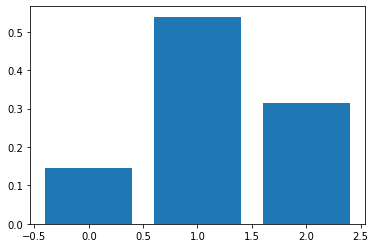

In [9]:
plt.bar(articles.Sentiment.value_counts().keys(), articles.Sentiment.value_counts() / sum(articles.Sentiment.value_counts()))

From the above plot, we can have a benchmark metric: if we just predict every sentence as 1, "neutral", regardless of its content, we would reach an accuracy around 55%. Therefore, our model has to beat this benchmark on validation set in order for us to use it for future inference.

In [10]:
data = tf.data.Dataset.from_tensor_slices((articles["Sentence"], articles["Sentiment"]))
data = data.batch(8)
data = data.shuffle(buffer_size = len(data), seed=1997)

In [11]:
train_size = int(0.7*len(data))
val_size   = int(0.1*len(data))

train = data.take(train_size)
val   = data.skip(train_size).take(val_size)
test  = data.skip(train_size + val_size)

# Bag-of-Bigrams

Bag of Bigrams is a set model: it looks at keywords only, but not order between words

In [12]:
from tensorflow.keras.layers import TextVectorization
text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=10000,
    output_mode="multi_hot")

In [13]:
text_vectorization.adapt(articles["Sentence"])

In [14]:
binary_2gram_train_ds = train.map( 
    lambda x, y: (text_vectorization(x), y), 
    num_parallel_calls=4) 
binary_2gram_val_ds = val.map( 
    lambda x, y: (text_vectorization(x), y), 
    num_parallel_calls=4) 
binary_2gram_test_ds = test.map( 
    lambda x, y: (text_vectorization(x), y), 
    num_parallel_calls=4) 

In [15]:
def get_model(max_tokens=10000, hidden_dim=16):
    inputs = keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation="relu")(inputs)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(3)(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"])
    return model

In [16]:
model = get_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10000)]           0         
                                                                 
 dense (Dense)               (None, 16)                160016    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 51        
                                                                 
Total params: 160,067
Trainable params: 160,067
Non-trainable params: 0
_________________________________________________________________


In [17]:
for d, t in binary_2gram_train_ds:
    print(d.shape)
    print(t.shape)
    print(t)
    break

(8, 10000)
(8,)
tf.Tensor([1 1 1 1 0 1 0 2], shape=(8,), dtype=int64)


In [18]:
callbacks = [
    keras.callbacks.ModelCheckpoint("binary_2gram.keras",
    save_best_only=True)
]
model.fit(binary_2gram_train_ds.cache(), 
    validation_data=binary_2gram_val_ds.cache(), 
    epochs=20,
    callbacks=callbacks)

Epoch 1/20
383/383 [==============================] - 2s 4ms/step - loss: 0.9227 - accuracy: 0.5885 - val_loss: 0.8150 - val_accuracy: 0.6690
Epoch 2/20
383/383 [==============================] - 1s 3ms/step - loss: 0.7585 - accuracy: 0.6969 - val_loss: 0.7017 - val_accuracy: 0.7153
Epoch 3/20
383/383 [==============================] - 1s 3ms/step - loss: 0.6442 - accuracy: 0.7413 - val_loss: 0.6253 - val_accuracy: 0.7431
Epoch 4/20
383/383 [==============================] - 1s 3ms/step - loss: 0.5644 - accuracy: 0.7786 - val_loss: 0.5719 - val_accuracy: 0.7685
Epoch 5/20
383/383 [==============================] - 1s 3ms/step - loss: 0.5139 - accuracy: 0.8024 - val_loss: 0.5298 - val_accuracy: 0.7940
Epoch 6/20
383/383 [==============================] - 1s 3ms/step - loss: 0.4528 - accuracy: 0.8259 - val_loss: 0.5033 - val_accuracy: 0.8079
Epoch 7/20
383/383 [==============================] - 1s 3ms/step - loss: 0.4221 - accuracy: 0.8396 - val_loss: 0.4839 - val_accuracy: 0.8218
Epoch 

In [19]:
model = keras.models.load_model("binary_2gram.keras") 
print(f"Test acc: {model.evaluate(binary_2gram_test_ds)[1]:.3f}")

111/111 [==============================] - 0s 2ms/step - loss: 0.5598 - accuracy: 0.8480
Test acc: 0.848


# BERT

BERT is a sequence model, where it looks at both keywords and their relatively position.

In [20]:
import tensorflow as tf
import tensorflow_text as text
import tensorflow_hub as hub
from official.nlp import optimization
tf.get_logger().setLevel('ERROR')


In [21]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
}

map_model_to_preprocess = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')


BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [22]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [23]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')


Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [24]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)


In [39]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(3, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)


In [40]:
classifier_model = build_classifier_model()


In [41]:
classifier_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                

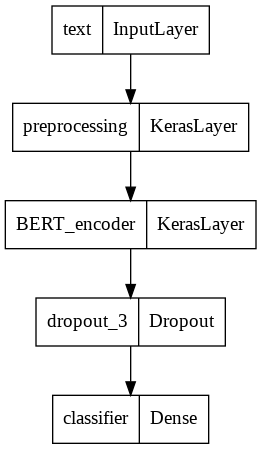

In [42]:
tf.keras.utils.plot_model(classifier_model)


In [43]:
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = "accuracy"
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')


In [44]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)


In [45]:
history = classifier_model.fit(x=train,
                               validation_data=val,
                               epochs=epochs)

Epoch 1/5
383/383 [==============================] - 213s 535ms/step - loss: 0.8589 - accuracy: 0.6025 - val_loss: 0.5624 - val_accuracy: 0.7894
Epoch 2/5
383/383 [==============================] - 206s 537ms/step - loss: 0.5606 - accuracy: 0.7552 - val_loss: 0.3824 - val_accuracy: 0.8403
Epoch 3/5
383/383 [==============================] - 208s 542ms/step - loss: 0.4182 - accuracy: 0.8191 - val_loss: 0.2839 - val_accuracy: 0.8704
Epoch 4/5
383/383 [==============================] - 210s 549ms/step - loss: 0.3665 - accuracy: 0.8354 - val_loss: 0.2681 - val_accuracy: 0.8698
Epoch 5/5
383/383 [==============================] - 212s 553ms/step - loss: 0.3177 - accuracy: 0.8573 - val_loss: 0.2009 - val_accuracy: 0.9028


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


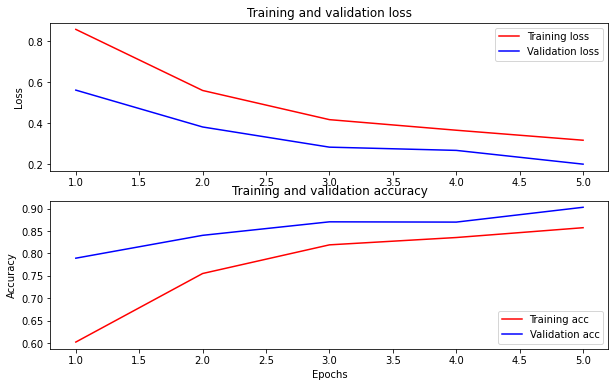

In [46]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


In [47]:
loss, accuracy = classifier_model.evaluate(test)


111/111 [==============================] - 20s 176ms/step - loss: 0.2440 - accuracy: 0.8930
